# APPNP実装

# APPNP（Approximate Personalized Propagation of Neural Predictions）実装

元論文：Predict then Propagate: Graph Neural Networks meet Personalized PageRank
Johannes Gasteiger, Aleksandar Bojchevski, Stephan Günnemann
ICLR 2019

https://arxiv.org/abs/1810.05997
参考にしたライブラリ：PyTorch Geometric

全体の流れ

1.   ライブラリのインストール
2.   汎用関数の定義
3.   APPNPモデル定義（2層MLP + APPNP伝播）
4.   グラフデータ読み込み（PyTorch Geometricでから読み込み）
5.   学習準備
6.   モデル学習（Early Stopping付き）
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

# PyTorch Geometricは使わずに、独自でAPPNPを実装
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu124


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [3]:
#乱数の固定化（改良版）

def seed_everything(seed: int = 42):
    """
    基本的な乱数固定（起動時のみ使用）
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        # GPU接続状態をチェックしてからCUDA乱数を設定
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

# グローバルに一度だけ実行
seed_everything(42)
print("初期乱数固定完了")
print(f"CUDA利用可能: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"使用GPU: {torch.cuda.get_device_name()}")

In [4]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [5]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# APPNPモデル定義

In [6]:
class APPNPNet(nn.Module):
    """
    APPNPモデル：2層MLPで初期特徴抽出 → APPNP伝播
    従来の隣接行列ベースの実装
    """
    def __init__(self, num_features, hidden_dim, num_classes, K, alpha, dropout):
        super(APPNPNet, self).__init__()

        # 2層MLP（特徴抽出）
        self.mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

        # APPNPパラメータ
        self.K = K
        self.alpha = alpha
        self.dropout = dropout

    def forward(self, x, adj):
        # 2層MLPで初期特徴抽出
        h0 = self.mlp(x)  # 初期予測 H0
        h = h0.clone()

        # APPNP伝播：K回のイテレーション
        for k in range(self.K):
            # ドロップアウト適用（学習時のみ）
            if self.training:
                h = F.dropout(h, p=self.dropout, training=self.training)

            # 伝播ステップ: H(k+1) = (1-α) * A_norm * H(k) + α * H0
            h = (1 - self.alpha) * torch.mm(adj, h) + self.alpha * h0

        return h


In [7]:
def accuracy(y_pred, y_true):
    """精度を計算する関数"""
    return (y_pred.argmax(dim=1) == y_true).float().mean()

# グラフデータ読み込み

# Coraデータセット読み込み

In [8]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773502588272095
  (20, 20)	0.40824830532073975
  (21, 21)	0.4472135901451111
  (22, 22)	0.40824830532073975
  (23, 23)	0.577350

In [9]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 5, 4,  ..., 1, 0, 3])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [10]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [11]:
# APPNPのハイパーパラメータ（条件通り）
alpha = 0.1         # テレポート確率
K = 10              # 伝播ステップ数
hidden_dim = 64     # 隠れ層次元数
dropout = 0.5       # ドロップアウト率

# APPNPモデルを作成
model = APPNPNet(num_features=features.shape[1],
                hidden_dim=hidden_dim,
                num_classes=num_classes,
                K=K,
                alpha=alpha,
                dropout=dropout)
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

APPNPNet(
  (mlp): Sequential(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=7, bias=True)
  )
)
Model parameters: 92231


In [12]:
# GPU設定とデータ移動
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

if torch.cuda.is_available():
    print("GPUでの処理を開始します")
    model = model.to(device)
    adj = adj.to(device)
    features = features.to(device)
    labels = labels.to(device)
    
    # GPU移動後の乱数固定を再実行
    torch.cuda.manual_seed_all(42)
    torch.cuda.synchronize()
else:
    print("CPUでの処理を開始します")

# Adam最適化手法（条件通り）
optimizer = torch.optim.Adam(model.parameters(),
                           lr=0.01,           # 学習率
                           weight_decay=5e-4) # 重み減衰
criterion = nn.CrossEntropyLoss()


In [13]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [14]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early stopping設定
use_early_stopping = True
patience = 100  # より適切なパラメータに変更

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch = 1000
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        y_pred_val = model(features, adj)  # 評価時は新しく予測
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch % 10 == 0: #10行毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.2f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.2f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

Epoch:    0 | Train loss: 1.962 | Train acc: 0.19 | Val loss: 1.882 | Val acc: 0.47
Epoch:   10 | Train loss: 0.744 | Train acc: 0.89 | Val loss: 0.874 | Val acc: 0.82
Epoch:   20 | Train loss: 0.308 | Train acc: 0.94 | Val loss: 0.594 | Val acc: 0.81
Epoch:   30 | Train loss: 0.165 | Train acc: 0.98 | Val loss: 0.701 | Val acc: 0.79
Epoch:   40 | Train loss: 0.126 | Train acc: 0.99 | Val loss: 0.823 | Val acc: 0.77
Epoch:   50 | Train loss: 0.115 | Train acc: 0.99 | Val loss: 0.665 | Val acc: 0.81
Epoch:   60 | Train loss: 0.120 | Train acc: 0.97 | Val loss: 0.744 | Val acc: 0.79
Epoch:   70 | Train loss: 0.129 | Train acc: 0.98 | Val loss: 0.687 | Val acc: 0.80
Epoch:   80 | Train loss: 0.095 | Train acc: 0.99 | Val loss: 0.670 | Val acc: 0.81
Epoch:   90 | Train loss: 0.066 | Train acc: 1.00 | Val loss: 0.686 | Val acc: 0.80
Epoch:  100 | Train loss: 0.100 | Train acc: 0.99 | Val loss: 0.844 | Val acc: 0.76
Epoch:  110 | Train loss: 0.071 | Train acc: 1.00 | Val loss: 0.814 | Val ac

# テスト精度の検証

In [15]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")

Test loss: 0.697  |  Test acc: 0.78


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

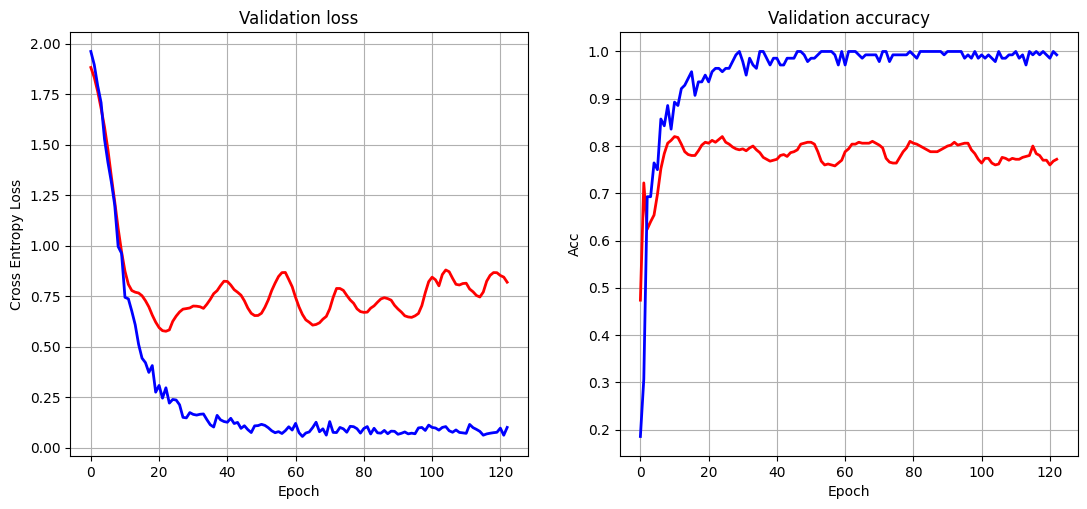

In [16]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red")
axs[0].plot(training_loss, linewidth=2, color="blue")
axs[0].set_title("Validation loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

# GPU テンソルをCPUに移動してからnumpyに変換
validation_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in validation_acc]
training_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in training_acc]

axs[1].plot(validation_acc_cpu, linewidth=2, color="red")
axs[1].plot(training_acc_cpu, linewidth=2, color="blue")
axs[1].set_title("Validation accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

In [ ]:
# パラメータ自動調整システム（改良版）

import itertools
import copy

def robust_seed_everything(seed: int = 42):
    """
    GPU接続状態に関係なく安定した乱数固定を行う関数
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # PyTorchの乱数固定
    torch.manual_seed(seed)
    
    # GPU利用可能時のみCUDA乱数を設定
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        # cudnnの設定を強制的に固定
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # GPU状態の同期を強制
        torch.cuda.synchronize()

def train_and_evaluate_model(alpha, K, hidden_dim, dropout, lr, weight_decay, features, labels, adj, train_set, validation_set, test_set):
    """
    指定されたパラメータでモデルを訓練し、テスト精度を返す（改良版）
    """
    
    # 改良された乱数固定
    robust_seed_everything(42)
    
    # モデル作成
    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=hidden_dim,
                    num_classes=num_classes,
                    K=K,
                    alpha=alpha,
                    dropout=dropout)
    
    # GPUに移動（GPU状態チェック付き）
    if torch.cuda.is_available():
        model.cuda()
        # GPU移動後の乱数固定を再実行
        torch.cuda.manual_seed_all(42)
    
    # オプティマイザー設定
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping設定
    use_early_stopping = True
    patience = 100
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False
    
    # 訓練ループ
    maxepoch = 1000
    for epoch in range(maxepoch):
        optimizer.zero_grad()
        model.train()
        
        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()
        
        # バリデーション評価
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
            
            if use_early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        stopped_early = True
                        break
    
    # テスト評価
    with torch.no_grad():
        model.eval()
        y_pred = model(features, adj)
        test_loss = criterion(y_pred[test_set], labels[test_set])
        test_acc = accuracy(y_pred[test_set], labels[test_set])
    
    return test_acc.item(), epoch + 1  # 実際のエポック数も返す


学習後のfeatureがラベルごとにかたまっている見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

In [17]:
# パラメータ自動調整システム

import itertools
import copy

def train_and_evaluate_model(alpha, K, hidden_dim, dropout, lr, weight_decay, features, labels, adj, train_set, validation_set, test_set):
    """
    指定されたパラメータでモデルを訓練し、テスト精度を返す
    """

    # 乱数シードを固定して再現性を保つ
    seed_everything(42)

    # モデル作成
    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=hidden_dim,
                    num_classes=num_classes,
                    K=K,
                    alpha=alpha,
                    dropout=dropout)

    # GPUに移動
    if torch.cuda.is_available():
        model.cuda()

    # オプティマイザー設定
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Early stopping設定
    use_early_stopping = True
    patience = 100
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

    # 訓練ループ
    maxepoch = 1000
    for epoch in range(maxepoch):
        optimizer.zero_grad()
        model.train()

        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()

        # バリデーション評価
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])

            if use_early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        stopped_early = True
                        break

    # テスト評価
    with torch.no_grad():
        model.eval()
        y_pred = model(features, adj)
        test_loss = criterion(y_pred[test_set], labels[test_set])
        test_acc = accuracy(y_pred[test_set], labels[test_set])

    return test_acc.item(), epoch + 1  # 実際のエポック数も返す

param_grid = {
    'alpha': [0.06],         # 0.1は外す
    'K': [14],                       # 10は外す
    'hidden_dim': [96],          # 64は外す
    'dropout': [0.45],              # 0.5は外す
    'lr': [0.009],        # 0.01は外す
    'weight_decay': [3e-4]   # 5e-4は外す
}

print("パラメータ自動調整を開始します...")
print(f"総組み合わせ数: {len(param_grid['alpha']) * len(param_grid['K']) * len(param_grid['hidden_dim']) * len(param_grid['dropout']) * len(param_grid['lr']) * len(param_grid['weight_decay'])}")


パラメータ自動調整を開始します...
総組み合わせ数: 1


In [18]:
# グリッドサーチ実行
import time

def grid_search_optimization():
    """
    グリッドサーチでパラメータ最適化を実行
    """

    best_acc = 0.0
    best_params = None
    results = []

    # 全組み合わせを生成
    param_combinations = list(itertools.product(
        param_grid['alpha'],
        param_grid['K'],
        param_grid['hidden_dim'],
        param_grid['dropout'],
        param_grid['lr'],
        param_grid['weight_decay']
    ))

    total_combinations = len(param_combinations)
    print(f"合計 {total_combinations} 個の組み合わせをテストします")

    start_time = time.time()

    for i, (alpha, K, hidden_dim, dropout, lr, weight_decay) in enumerate(param_combinations):
        print(f"\n進捗: {i+1}/{total_combinations}")
        print(f"テスト中のパラメータ: alpha={alpha}, K={K}, hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}")

        try:
            # モデル訓練・評価
            test_acc, epochs = train_and_evaluate_model(
                alpha, K, hidden_dim, dropout, lr, weight_decay,
                features, labels, adj, train_set, validation_set, test_set
            )

            print(f"テスト精度: {test_acc:.4f} (エポック数: {epochs})")

            # 結果を記録
            result = {
                'alpha': alpha,
                'K': K,
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'weight_decay': weight_decay,
                'test_acc': test_acc,
                'epochs': epochs
            }
            results.append(result)

            # ベスト結果更新
            if test_acc > best_acc:
                best_acc = test_acc
                best_params = result.copy()
                print(f"🎉 新しい最高精度! {best_acc:.4f}")

        except Exception as e:
            print(f"エラー発生: {e}")
            continue

        # 進捗時間表示
        elapsed = time.time() - start_time
        avg_time = elapsed / (i + 1)
        remaining = avg_time * (total_combinations - i - 1)
        print(f"経過時間: {elapsed/60:.1f}分, 推定残り時間: {remaining/60:.1f}分")

    return best_params, best_acc, results

# 最適化実行
print("グリッドサーチ最適化を開始します...")
best_params, best_acc, all_results = grid_search_optimization()

print(f"\n🏆 最適化完了!")
print(f"最高テスト精度: {best_acc:.4f}")
print("最適パラメータ:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


グリッドサーチ最適化を開始します...
合計 1 個の組み合わせをテストします

進捗: 1/1
テスト中のパラメータ: alpha=0.06, K=14, hidden_dim=96, dropout=0.45, lr=0.009, weight_decay=0.0003
テスト精度: 0.7650 (エポック数: 119)
🎉 新しい最高精度! 0.7650
経過時間: 0.0分, 推定残り時間: 0.0分

🏆 最適化完了!
最高テスト精度: 0.7650
最適パラメータ:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003
  test_acc: 0.765
  epochs: 119


In [19]:
# 結果の詳細分析と可視化

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(results):
    """
    グリッドサーチ結果の詳細分析
    """

    # DataFrameに変換
    df = pd.DataFrame(results)

    print("📊 結果統計:")
    print(f"平均テスト精度: {df['test_acc'].mean():.4f}")
    print(f"標準偏差: {df['test_acc'].std():.4f}")
    print(f"最高精度: {df['test_acc'].max():.4f}")
    print(f"最低精度: {df['test_acc'].min():.4f}")

    # 上位10結果を表示
    print("\n🏆 上位10結果:")
    top_results = df.nlargest(10, 'test_acc')
    for i, row in top_results.iterrows():
        print(f"{len(top_results) - list(top_results.index).index(i)}位: 精度 {row['test_acc']:.4f} | "
              f"alpha={row['alpha']}, K={row['K']}, hidden_dim={row['hidden_dim']}, "
              f"dropout={row['dropout']}, lr={row['lr']}, weight_decay={row['weight_decay']}")

    # 各パラメータの影響を分析
    print("\n📈 パラメータ別平均精度:")
    for param in ['alpha', 'K', 'hidden_dim', 'dropout', 'lr', 'weight_decay']:
        param_analysis = df.groupby(param)['test_acc'].agg(['mean', 'std', 'count'])
        print(f"\n{param}:")
        for value, stats in param_analysis.iterrows():
            print(f"  {value}: 平均 {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")

    return df, top_results

# 結果分析実行
print("結果分析を開始します...")
results_df, top_10 = analyze_results(all_results)


結果分析を開始します...
📊 結果統計:
平均テスト精度: 0.7650
標準偏差: nan
最高精度: 0.7650
最低精度: 0.7650

🏆 上位10結果:
1位: 精度 0.7650 | alpha=0.06, K=14.0, hidden_dim=96.0, dropout=0.45, lr=0.009, weight_decay=0.0003

📈 パラメータ別平均精度:

alpha:
  0.06: 平均 0.7650 ± nan (n=1.0)

K:
  14: 平均 0.7650 ± nan (n=1.0)

hidden_dim:
  96: 平均 0.7650 ± nan (n=1.0)

dropout:
  0.45: 平均 0.7650 ± nan (n=1.0)

lr:
  0.009: 平均 0.7650 ± nan (n=1.0)

weight_decay:
  0.0003: 平均 0.7650 ± nan (n=1.0)


In [20]:
# 最適パラメータでの最終検証

def final_validation_with_best_params(best_params):
    """
    最適パラメータでモデルを再訓練し、詳細な結果を取得
    """

    print("🔍 最適パラメータでの最終検証を実行します...")
    print("パラメータ:")
    for key, value in best_params.items():
        if key not in ['test_acc', 'epochs']:
            print(f"  {key}: {value}")

    # 最適パラメータで再度訓練
    seed_everything(42)  # 再現性確保

    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=best_params['hidden_dim'],
                    num_classes=num_classes,
                    K=best_params['K'],
                    alpha=best_params['alpha'],
                    dropout=best_params['dropout'])

    if torch.cuda.is_available():
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(),
                               lr=best_params['lr'],
                               weight_decay=best_params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    # 訓練過程を記録
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 100

    print("\n訓練開始...")
    for epoch in range(1000):
        # 訓練
        optimizer.zero_grad()
        model.train()
        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_acc = accuracy(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

        # バリデーション
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
            val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # 最終テスト
    with torch.no_grad():
        model.eval()
        y_pred_final = model(features, adj)
        test_loss = criterion(y_pred_final[test_set], labels[test_set])
        test_acc = accuracy(y_pred_final[test_set], labels[test_set])

    print(f"\n✅ 最終結果:")
    print(f"テスト損失: {test_loss:.4f}")
    print(f"テスト精度: {test_acc:.4f}")
    print(f"訓練エポック数: {epoch + 1}")

    return {
        'model': model,
        'test_acc': test_acc.item(),
        'test_loss': test_loss.item(),
        'epochs': epoch + 1,
        'train_history': {
            'loss': train_losses,
            'acc': train_accs
        },
        'val_history': {
            'loss': val_losses,
            'acc': val_accs
        }
    }

# 最終検証実行
final_results = final_validation_with_best_params(best_params)

print(f"\n🎯 最終的な最適パラメータとテスト精度:")
print(f"テスト精度: {final_results['test_acc']:.4f}")
print("最適パラメータ:")
for key, value in best_params.items():
    if key not in ['test_acc', 'epochs']:
        print(f"  {key}: {value}")


🔍 最適パラメータでの最終検証を実行します...
パラメータ:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003

訓練開始...
Epoch 0: Train Loss=1.9468, Train Acc=0.1714, Val Loss=1.8999, Val Acc=0.2020
Epoch 50: Train Loss=0.0904, Train Acc=0.9857, Val Loss=0.7250, Val Acc=0.7940
Epoch 100: Train Loss=0.1730, Train Acc=0.9786, Val Loss=1.0115, Val Acc=0.7440

✅ 最終結果:
テスト損失: 0.8220
テスト精度: 0.7650
訓練エポック数: 119

🎯 最終的な最適パラメータとテスト精度:
テスト精度: 0.7650
最適パラメータ:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003


<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  plt.tigh

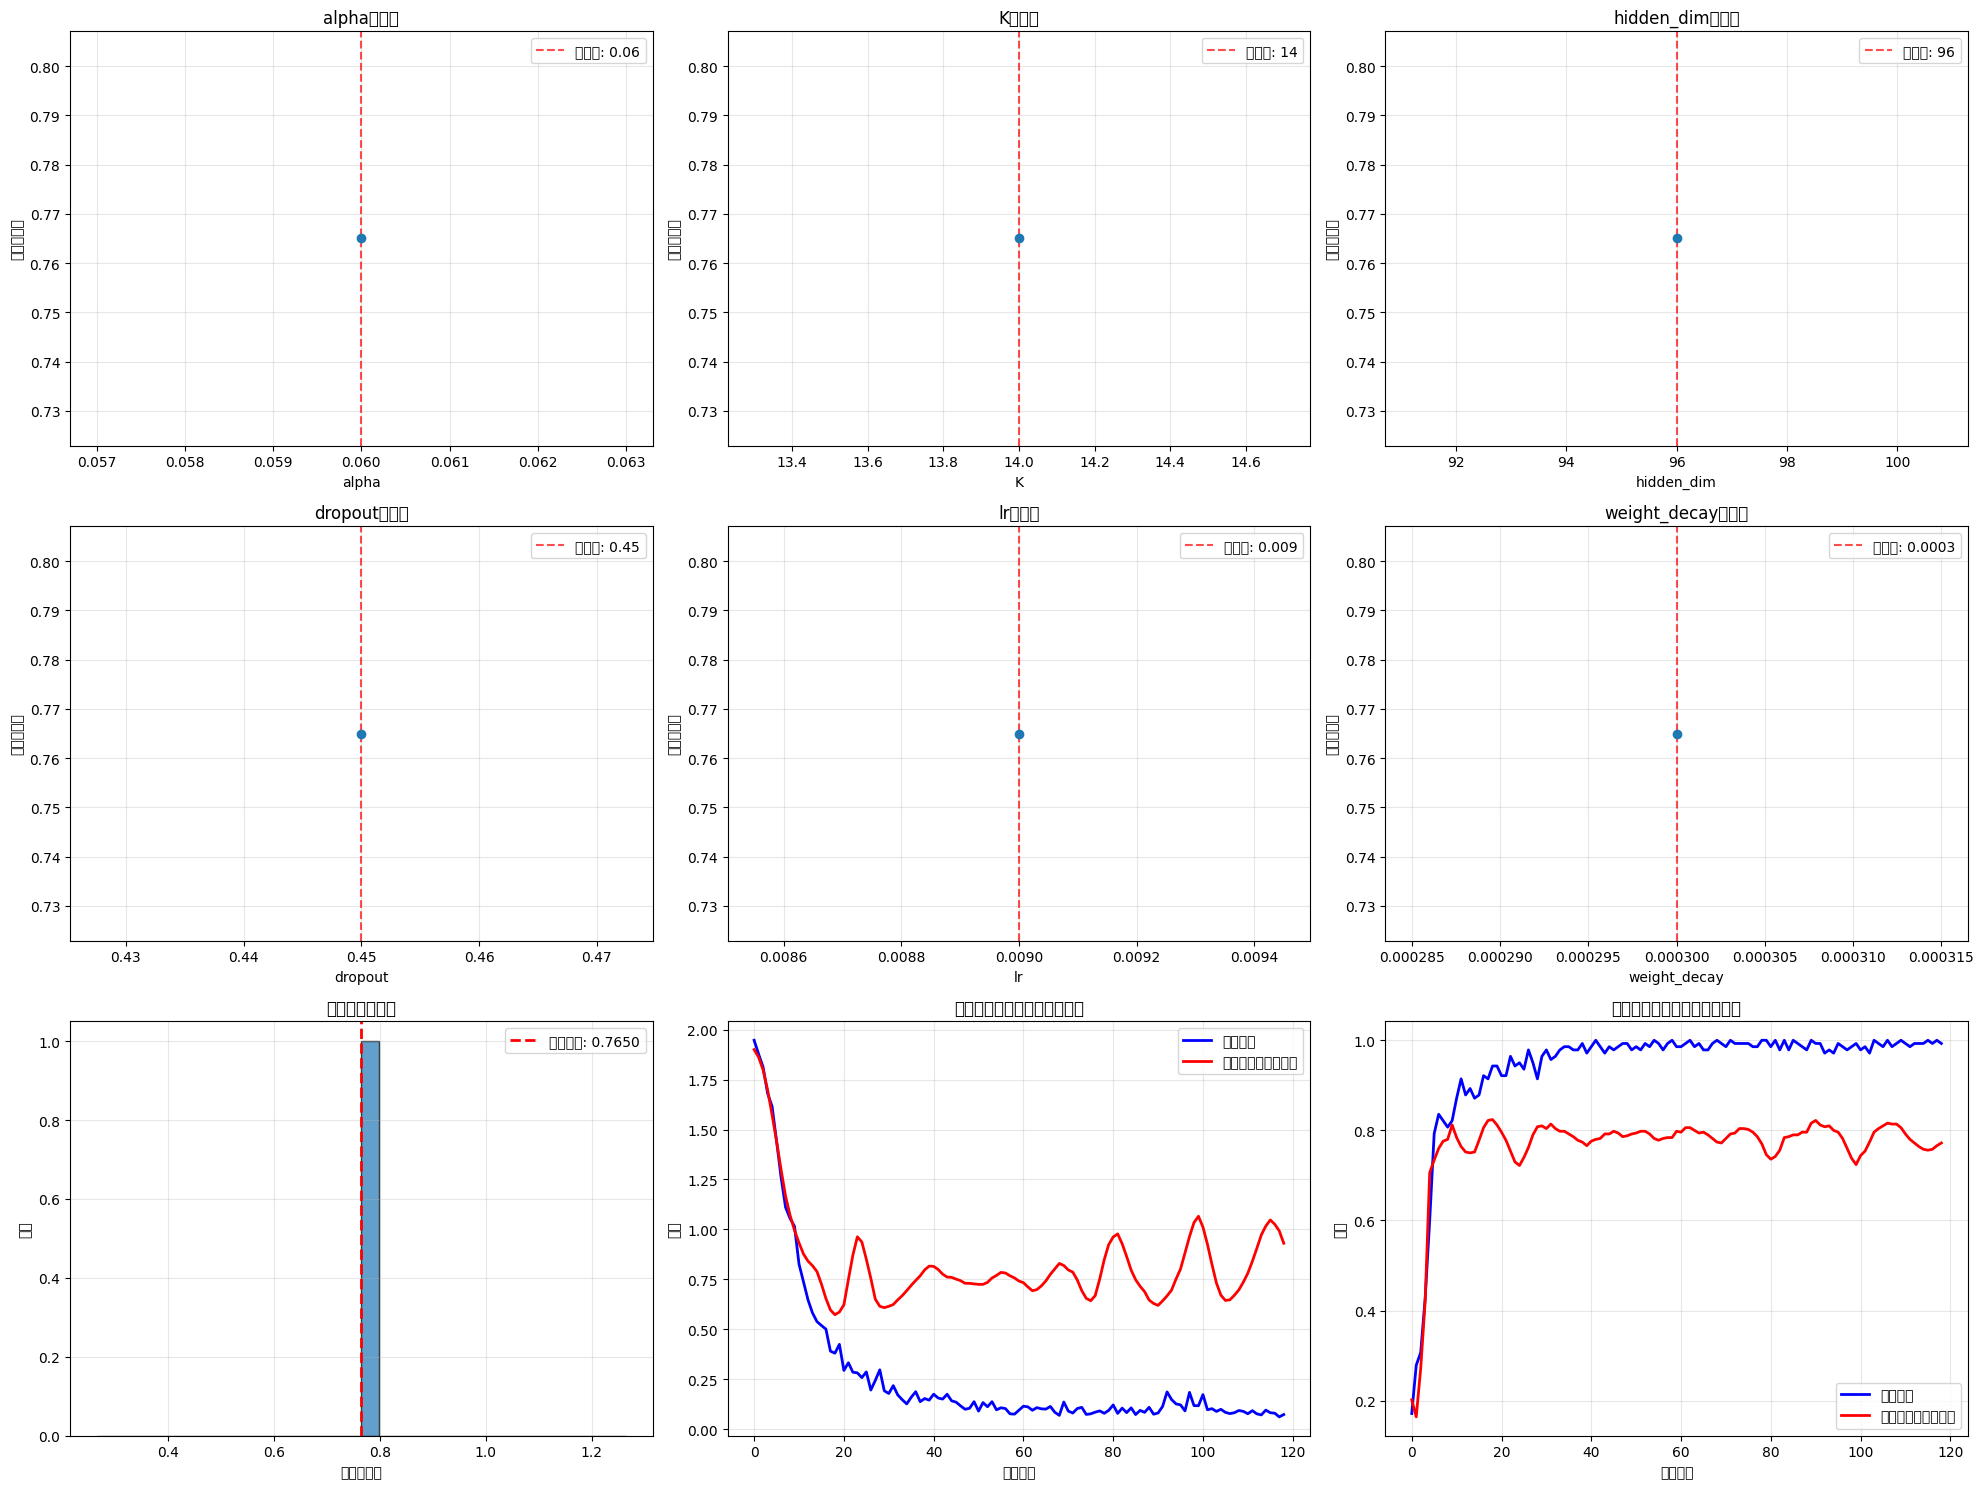

結果をCSVファイルに保存しました: /content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv


In [21]:
# 結果の可視化

def plot_optimization_results(results_df, final_results):
    """
    最適化結果の可視化
    """

    plt.figure(figsize=(20, 15))

    # 1. パラメータ別精度分布
    params_to_plot = ['alpha', 'K', 'hidden_dim', 'dropout', 'lr', 'weight_decay']

    for i, param in enumerate(params_to_plot, 1):
        plt.subplot(3, 3, i)
        param_groups = results_df.groupby(param)['test_acc'].agg(['mean', 'std'])

        x = param_groups.index
        y = param_groups['mean']
        yerr = param_groups['std']

        plt.errorbar(x, y, yerr=yerr, marker='o', capsize=3, capthick=2)
        plt.title(f'{param}の影響')
        plt.xlabel(param)
        plt.ylabel('テスト精度')
        plt.grid(True, alpha=0.3)

        # 最適値をハイライト
        if param in best_params:
            best_val = best_params[param]
            plt.axvline(x=best_val, color='red', linestyle='--', alpha=0.7, label=f'最適値: {best_val}')
            plt.legend()

    # 2. 精度分布ヒストグラム
    plt.subplot(3, 3, 7)
    plt.hist(results_df['test_acc'], bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=final_results['test_acc'], color='red', linestyle='--', linewidth=2, label=f'最高精度: {final_results["test_acc"]:.4f}')
    plt.title('テスト精度分布')
    plt.xlabel('テスト精度')
    plt.ylabel('頻度')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 訓练过程可视化
    plt.subplot(3, 3, 8)
    epochs_range = range(len(final_results['train_history']['loss']))
    plt.plot(epochs_range, final_results['train_history']['loss'], 'b-', label='訓練損失', linewidth=2)
    plt.plot(epochs_range, final_results['val_history']['loss'], 'r-', label='バリデーション損失', linewidth=2)
    plt.title('最適パラメータでの損失変化')
    plt.xlabel('エポック')
    plt.ylabel('損失')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 9)
    plt.plot(epochs_range, final_results['train_history']['acc'], 'b-', label='訓練精度', linewidth=2)
    plt.plot(epochs_range, final_results['val_history']['acc'], 'r-', label='バリデーション精度', linewidth=2)
    plt.title('最適パラメータでの精度変化')
    plt.xlabel('エポック')
    plt.ylabel('精度')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 可視化実行
plot_optimization_results(results_df, final_results)

# 結果をCSVファイルに保存
results_df.to_csv('/content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv', index=False)
print("結果をCSVファイルに保存しました: /content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv")


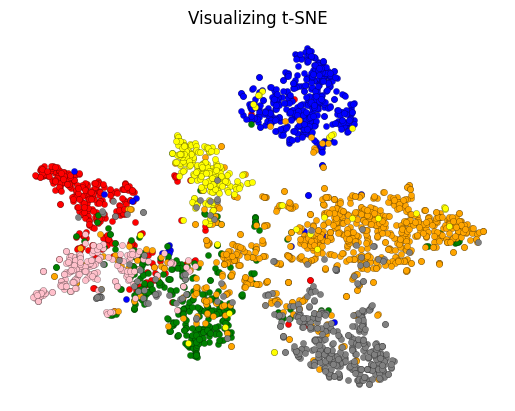

In [22]:
visualize_embedding_tSNE(labels, y_pred, num_classes)